# Solución hidrostática de una estrella de neutrones degenerados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline

## Ecuacion de estado del gas

El gas degenedaro de neutrones presenta las relaciones:

$$ \hat P = A f(x)/P_0, $$
$$ \rho_m = B * x^3, $$
$$ u = A * (8x^3(\sqrt{1+x^2}-1)-f(x))$$
$$ \hat \rho = (c^2\rho_m + u)/\rho_0$$

donde

$$ f(x) = x\sqrt{x^2+1}(2x^2-3) + 3 ln(x+\sqrt{1+x^2}), $$

con

$$ A = \frac{\pi m_n^4 c^5}{3h^3},$$
$$ B = \frac{8 \pi m_n^3 c^3 \mu_n}{3h^3 N_0} = \frac{8 \mu_n}{m_n c^2 N_0}A$$

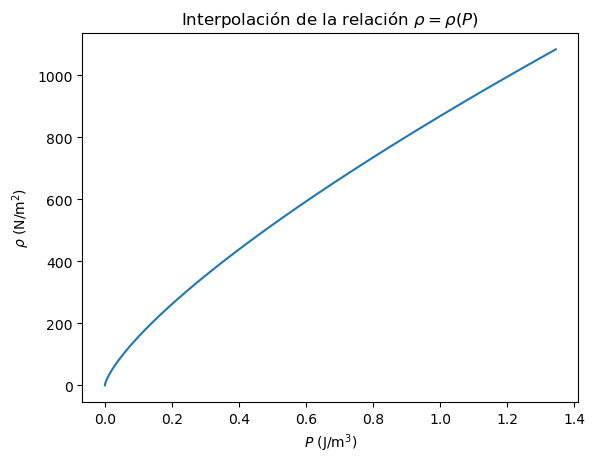

In [2]:
# Definimos constantes
pi = np.pi
m_n = 1.67e-27 # Masa del neutrón en kg
c = 3e8 # Velocidad de la luz en m/s
h = 6.63e-34 # Constante de Planck en Js
mu_n = 2 # Mean molecular weight per free neutron
N0 = 6.022e23 # Número de Avogadro
G = 6.67e-11 # Constante de gravitación universal en m^3/kg/s^2

A = pi*m_n**4*c**5/(3*h**3) 
B = 8*pi*m_n**3*c**3*mu_n/(3*h**3*N0)

# Definimos la función f
def f(x):
    return x*np.sqrt(1+x**2)*(2*x**2-3)+3*np.log(x+np.sqrt(1+x**2))

# Definimos la presion y densidad de energía en función del parámetro x y la densidad central (rho0 = P0)
def preasure(x, P0):
    return A*f(x)/P0
def density(x, rho0):
    return ( c**2*B*x**3 + A*(8*x**3*(np.sqrt(1+x**2)-1)-f(x)) )/rho0

# Definimos la interpolacion de la relacion rho = rho(P)
def EoS(rho0, x):
    return CubicSpline(preasure(x, rho0), density(x, rho0))
    
# Ejemplo
rho0 = 1e39 # Densidad central de energía
x = np.linspace(0, 10, 1000)
rho_P = EoS(rho0, x)
plt.plot(preasure(x, rho0), rho_P(preasure(x, rho0)))
plt.xlabel(r'$P$ (J/m$^3$)')
plt.ylabel(r'$\rho$ (N/m$^2$)')
plt.title(r'Interpolación de la relación $\rho = \rho(P)$')
plt.show()

## Sistemas de ecuaciones

Definiciones útiles en ambos sistemas de ecuaciones:

In [49]:
# Malla de integración para ambos sistemas
rf = 10 # Radio adimensional final
dr = 1e-3 # Paso de integración
N = int(rf/dr) # Número de puntos
r = np.linspace(dr, rf, N) # Puntos de integración

# Definimos una función para convertir las cantidades adimensionales a cantidades físicas
# la adimensionalización es identica en Newton y en GR
def adimensional_to_fisico(sol_fin, rho0):
    P, m, phi, rho = sol_fin
    
    # Obtenemos las constantes de adimensionalización
    P0 = rho0
    R = np.sqrt(c**4/(4*pi*G*rho0))
    M = 4*pi*R**3*rho0

    # Convertimos las cantidades adimensionales a cantidades físicas
    P_fisico = P0*P
    m_fisico = M*m
    phi_fisico = phi
    rho_fisico = rho0*rho

    return [P_fisico, m_fisico, phi_fisico, rho_fisico, R, M]

# Realizamos la interpolacion de la relación rho = rho(P)
x = np.linspace(0, 10, 1000)
rho0 = 1e39 # Densidad central de energía kg/m/s^2
# rho0 = 1 # Densidad central de energía kg/m/s^2
rho_P = EoS(rho0, x)
P_central = CubicSpline(density(x, rho0), preasure(x, rho0))(1) # Presion obtenida de la ecuacion de estado para rho=1
rho_P(P_central)

array(1.00000001)

### Newton

Ecuaciones de equilibrio hidrostático:

$$\frac{d\hat m}{d \hat r} =\alpha \hat r^2 \hat \rho; \quad \alpha = \frac{4 \pi R^3 \rho_0}{M c^2}$$
$$\frac{d \hat P}{d \hat r} = -\beta\frac{\hat m \hat \rho}{\hat r^2}; \quad \beta = \frac{\rho_0}{P_0}\lambda$$
$$\frac{d \phi}{d \hat r} = \lambda\frac{\hat m}{\hat r^2}; \quad \lambda = \frac{G M}{c^2 R}$$

donde tomando las constantes igual a 1, se tiene, en MKS:

$$P_0 = \rho_0$$
$$M = 4 \pi R^3 \rho_0$$
$$R^2 = \frac{c^4}{4 \pi G \rho_0}$$

Escogiendo la densidad central como la de la estrella, $\hat \rho(0) = 1$, $\hat m(0) = 0$. 

In [50]:
# Definimos el sistema de ecuaciones newtonianas
def newtonianas(sol, r, rho_P):
    # Tomamos las variables
    P, m, phi = sol # Presion, masa y potencial adimensionales

    # Usamos la ecuación de estado para la densidad de energía
    rho = rho_P(P) # Densidad de energia adimensional

    # Definimos las derivadas
    dm_dr = r**2 * rho
    dP_dr = -m*rho/r**2
    dphi_dr = m/r**2

    # Devolvemos las derivadas
    return [dP_dr, dm_dr, dphi_dr]

# Definimos las condiciones iniciales en r = dr (para evitar la singularidad en r = 0)
# estas son cantidades adimensionales, así que rho(0) = 1 y m(0) = 0
m0_N = dr**3/3 # m = 0 + 0r + 0r^2/2 + 2rho(0)r^3/6 ...
P0_N = P_central-dr**2/6 # P = P(0) + 0r -1/3*r^2/2 ...
# P0 = 1 - dr**2/6
phi0_N = 1 + dr**2/6 # phi = 1 + 0r + 1/3*r^2/2 ...

# Resolvemos el sistema de ecuaciones
sol_N = odeint(newtonianas, [P0_N, m0_N, phi0_N], r, args=(rho_P,)).T

In [51]:
# rho_P(P_central)
P0_N

7.398731141153833e-05

Radio de la estrella:  0.055  en el paso  54


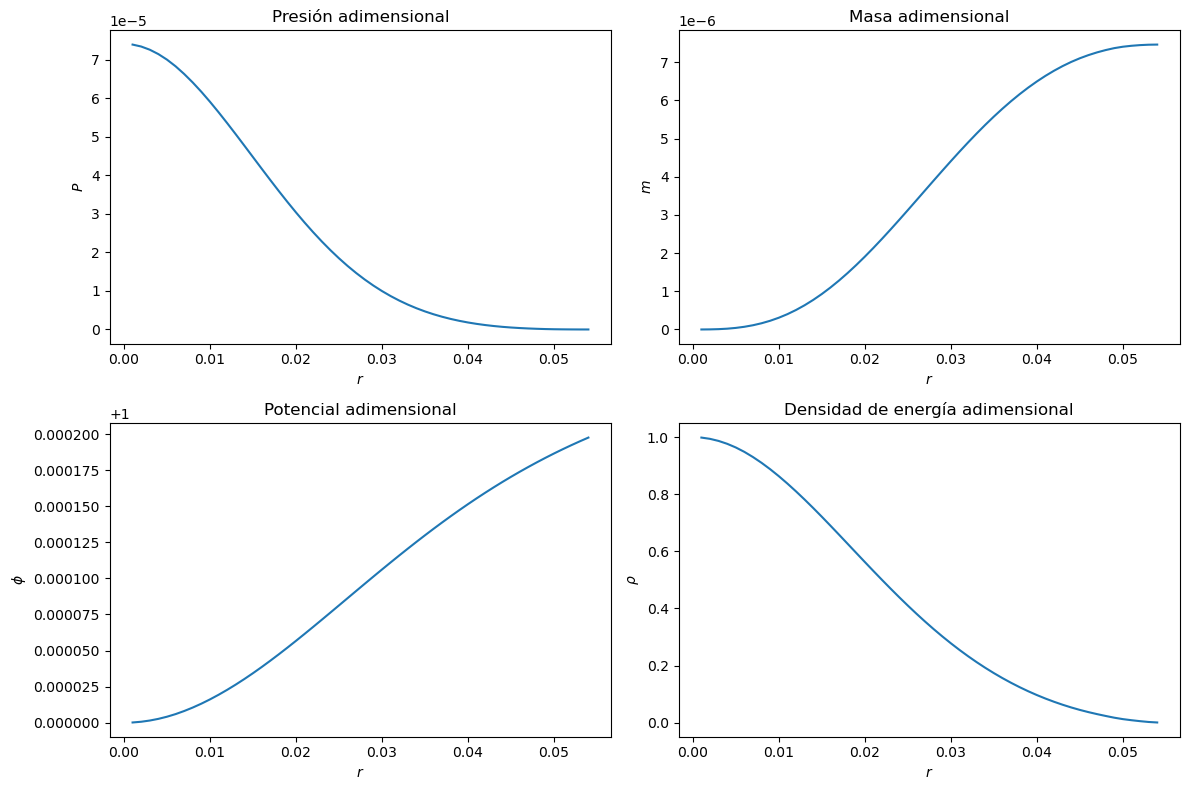

In [52]:
# Obtenemos la densidad a partir de las presiones
P_N, m_N, phi_N = sol_N
rho_N = rho_P(P_N)

# Buscamos el radio donde la densidad es cero
lim_N = len(r)
for i in range(len(rho_N)):
    if rho_N[i] <= 0:
        # print(r[i], x[i,0])
        lim_N = i
        break
print("Radio de la estrella: ", r[lim_N], " en el paso ", lim_N)

# Obtenemos las cantidades finales
sol_fin_N = [P_N[lim_N], m_N[lim_N], phi_N[lim_N], rho_N[lim_N]]

# Graficamos las soluciones
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].plot(r[:lim_N], P_N[:lim_N], label=r'$P$')
ax[0, 0].set_xlabel(r'$r$')
ax[0, 0].set_ylabel(r'$P$')
ax[0, 0].set_title(r'Presión adimensional')

ax[0, 1].plot(r[:lim_N], m_N[:lim_N], label=r'$m$')
ax[0, 1].set_xlabel(r'$r$')
ax[0, 1].set_ylabel(r'$m$')
ax[0, 1].set_title(r'Masa adimensional')

ax[1, 0].plot(r[:lim_N], phi_N[:lim_N], label=r'$\phi$')
ax[1, 0].set_xlabel(r'$r$')
ax[1, 0].set_ylabel(r'$\phi$')
ax[1, 0].set_title(r'Potencial adimensional')

ax[1, 1].plot(r[:lim_N], rho_N[:lim_N], label=r'$\rho$')
ax[1, 1].set_xlabel(r'$r$')
ax[1, 1].set_ylabel(r'$\rho$')
ax[1, 1].set_title(r'Densidad de energía adimensional')

plt.tight_layout()
plt.show()

In [53]:
# Convertimos las cantidades adimensionales a cantidades físicas
sol_fin_fisico_N = adimensional_to_fisico(sol_fin_N, rho0)
print("Presión en el centro de la estrella: ", sol_fin_fisico_N[0], " N/m^2")
print("Masa de la estrella: ", sol_fin_fisico_N[1], " kg")
print("Radio de la estrella: ", sol_fin_fisico_N[4], " m")  

Presión en el centro de la estrella:  -1.508746346040251e+29  N/m^2
Masa de la estrella:  8.90921355614159e+40  kg
Radio de la estrella:  98.30478562813687  m


### Relativista

Ecuaciones de equilibrio hidrostático:

$$\frac{d\hat m}{d \hat r} =\alpha \hat r^2 \hat \rho; \quad \alpha = \frac{4 \pi R^3 \rho_0}{M c^2}$$
$$\frac{d \hat P}{d \hat r} = -\beta\frac{\hat m \hat \rho}{\hat r^2}\left( 1+\gamma \frac{\hat P}{\hat \rho} \right) \left( 1+ \alpha \gamma \frac{\hat r^3 \hat P}{\hat m} \right) \left( 1- \lambda \frac{2 \hat m}{\hat r} \right)^{-1}; \quad \beta = \frac{\lambda}{\gamma}, \quad \gamma = \frac{P_0}{\rho_0}, \quad \lambda = \frac{G M}{c^2 R}$$
$$\frac{d \phi}{d \hat r} = -\frac{\gamma}{\hat \rho + \gamma \hat P} \frac{d \hat P}{d\hat r}.$$

donde tomando las constantes igual a 1, se tiene, en MKS:

$$P_0 = \rho_0$$
$$M = 4 \pi R^3 \rho_0$$
$$R^2 = \frac{c^4}{4 \pi G \rho_0}$$

Escogiendo la densidad central como la de la estrella, $\hat \rho(0) = 1$, $\hat m(0) = 0$. 

In [54]:
# Definimos el sistema de ecuaciones relativistas
def relativistas(sol, r, rho_P):
    # Tomamos las variables
    P, m, phi = sol # Presion, masa y potencial adimensionales

    # Usamos la ecuación de estado para la densidad de energía
    rho = rho_P(P) # Densidad de energia adimensional

    # Definimos las derivadas
    dm_dr = r**2 * rho
    dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)
    dphi_dr = -dP_dr/(rho + P)

    # Devolvemos las derivadas
    return [dP_dr, dm_dr, dphi_dr]

# Definimos las condiciones iniciales en r = dr (para evitar la singularidad en r = 0)
# estas son cantidades adimensionales, así que rho(0) = 1 y m(0) = 0
m0_R = dr**3/3 # m = 0 + 0r + 0r^2/2 + 2rho(0)r^3/6 ...
P0_R = P_central-(3*P_central**2+4*P_central+1)*dr**2/6 # P = P(0) + 0r -1/3*(3P(0)^2+4P(0)+1)*r^2/2 ...
# P0 = 1 - dr**2/6
phi0_R = 1 + (1/3+P_central)*dr**2/2 # phi = 1 + 0r + 1/3*r^2/2 ...

# Resolvemos el sistema de ecuaciones
sol_R = odeint(relativistas, [P0_R, m0_R, phi0_R], r, args=(rho_P,)).T

In [55]:
P0_R-P0_N

-4.943873479004712e-11

Radio de la estrella:  0.055  en el paso  54


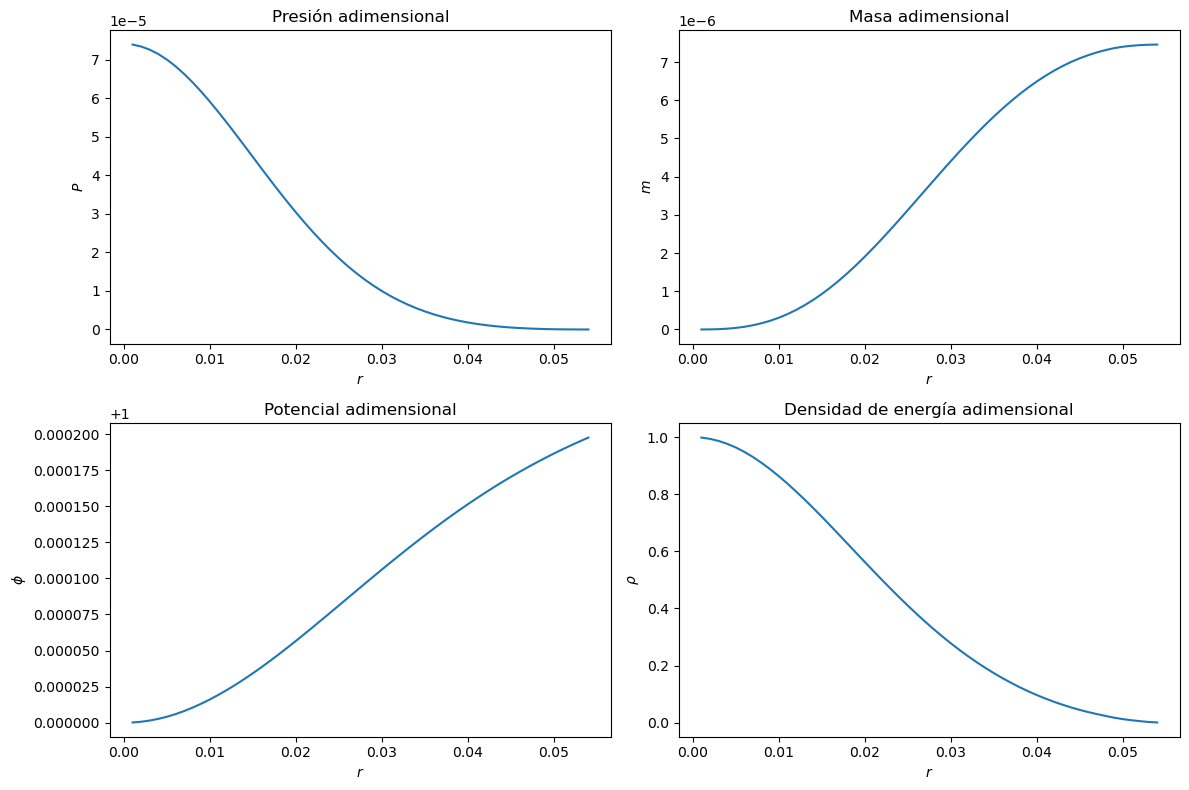

In [56]:
# Obtenemos la densidad a partir de las presiones
P_R, m_R, phi_R = sol_R
rho_R = rho_P(P_R)

# Buscamos el radio donde la densidad es cero
lim_R = len(r)
for i in range(len(rho_R)):
    if rho_N[i] <= 0:
        # print(r[i], x[i,0])
        lim_R = i
        break
print("Radio de la estrella: ", r[lim_R], " en el paso ", lim_R)

# Obtenemos las cantidades finales
sol_fin_R = [P_R[lim_R], m_R[lim_R], phi_R[lim_R], rho_R[lim_R]]

# Graficamos las soluciones
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].plot(r[:lim_R], P_R[:lim_R], label=r'$P$')
ax[0, 0].set_xlabel(r'$r$')
ax[0, 0].set_ylabel(r'$P$')
ax[0, 0].set_title(r'Presión adimensional')

ax[0, 1].plot(r[:lim_R], m_R[:lim_R], label=r'$m$')
ax[0, 1].set_xlabel(r'$r$')
ax[0, 1].set_ylabel(r'$m$')
ax[0, 1].set_title(r'Masa adimensional')

ax[1, 0].plot(r[:lim_R], phi_R[:lim_R], label=r'$\phi$')
ax[1, 0].set_xlabel(r'$r$')
ax[1, 0].set_ylabel(r'$\phi$')
ax[1, 0].set_title(r'Potencial adimensional')

ax[1, 1].plot(r[:lim_R], rho_R[:lim_R], label=r'$\rho$')
ax[1, 1].set_xlabel(r'$r$')
ax[1, 1].set_ylabel(r'$\rho$')
ax[1, 1].set_title(r'Densidad de energía adimensional')

plt.tight_layout()
plt.show()

In [57]:
# Convertimos las cantidades adimensionales a cantidades físicas
sol_fin_fisico_R = adimensional_to_fisico(sol_fin_R, rho0)
print("Presión en el centro de la estrella: ", sol_fin_fisico_R[0], " N/m^2")
print("Masa de la estrella: ", sol_fin_fisico_R[1], " kg")
print("Radio de la estrella: ", sol_fin_fisico_R[4], " m")


Presión en el centro de la estrella:  -1.4586957996938586e+29  N/m^2
Masa de la estrella:  8.90427472432164e+40  kg
Radio de la estrella:  98.30478562813687  m
